In [1]:
!pip install langchain langgraph cassio --quiet

!pip install langchain_community --quiet

!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface --quiet

!pip install langchain_community --quiet

!pip install arxiv wikipedia --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires requests-toolbelt<1,>=0.8.0, but you have requests-toolbelt 1.0.0 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 

In [2]:
import cassio

## connection of the ASTRA DB

ASTRA_DB_APPLICATION_TOKEN="AstraCS:qwajTvwIHlzBuZhUnnceYfwc:e6d7965c501a0444aa9b330e74ea21a2c944f56ae77ff2b2474b29a51e9b5eca" # enter the "AstraCS:..." string found in in your Token JSON file"

ASTRA_DB_ID="8ffdffd9-6fd9-4e26-b33c-1c0a2313f38a"

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [3]:
### Build Index



from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import WebBaseLoader

from langchain_community.vectorstores import Chroma





### from langchain_cohere import CohereEmbeddings







# Docs to index

urls = [

    "https://lilianweng.github.io/posts/2023-06-23-agent/",

    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",

    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",

]



# Load

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]



# Split

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(

    chunk_size=500, chunk_overlap=0

)

doc_splits = text_splitter.split_documents(docs_list)




In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
from langchain.vectorstores.cassandra import Cassandra

astra_vector_store=Cassandra(

    embedding=embeddings,

    table_name="langgraph_wiki_search_with_Astradb",

    session=None,

    keyspace=None



)

In [6]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

astra_vector_store.add_documents(doc_splits)

print("Inserted %i headlines." % len(doc_splits))



astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [7]:
retriever=astra_vector_store.as_retriever()

In [8]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='a5d6dad254ce4f92922dfc3c0d48a441', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for p

In [9]:
### Router



from typing import Literal



from langchain_core.prompts import ChatPromptTemplate

from langchain_core.pydantic_v1 import BaseModel, Field







# Data model

class RouteQuery(BaseModel):

    """Route a user query to the most relevant datasource."""



    datasource: Literal["vectorstore", "wiki_search"] = Field(

        ...,

        description="Given a user question choose to route it to wikipedia or a vectorstore.",

    )





# LLM with function call

from langchain_groq import ChatGroq

import os

groq_api_key= "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"

os.environ["GROQ_API_KEY"]=groq_api_key

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

structured_llm_router = llm.with_structured_output(RouteQuery)



# Prompt

system = """You are an expert at routing a user question to a vectorstore or wikipedia.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.

Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages(

    [

        ("system", system),

        ("human", "{question}"),

    ]

)



question_router = route_prompt | structured_llm_router

print(

    question_router.invoke(

        {"question": "who is  Andrew Tate ?"}

    )

)

print(question_router.invoke({"question": "What are the types of agent memory?"}))

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


datasource='wiki_search'
datasource='vectorstore'


In [10]:
### Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun



## Arxiv and wikipedia Tools

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)

arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)



api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)

wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

wiki

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/opt/conda/lib/python3.10/site-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=200))

In [11]:
## Graph



from typing import List



from typing_extensions import TypedDict





class GraphState(TypedDict):

    """

    Represents the state of our graph.



    Attributes:

        question: question

        generation: LLM generation

        documents: list of documents

    """



    question: str

    generation: str

    documents: List[str]

In [12]:
from langchain.schema import Document





def retrieve(state):

    """

    Retrieve documents



    Args:

        state (dict): The current graph state



    Returns:

        state (dict): New key added to state, documents, that contains retrieved documents

    """

    print("---RETRIEVE---")

    question = state["question"]



    # Retrieval

    documents = retriever.invoke(question)

    return {"documents": documents, "question": question}

In [13]:
def wiki_search(state):

    """

    wiki search based on the re-phrased question.



    Args:

        state (dict): The current graph state



    Returns:

        state (dict): Updates documents key with appended web results

    """



    print("---wikipedia---")

    print("---HELLO--")

    question = state["question"]

    print(question)



    # Wiki search

    docs = wiki.invoke({"query": question})

    #print(docs["summary"])

    wiki_results = docs

    wiki_results = Document(page_content=wiki_results)



    return {"documents": wiki_results, "question": question}

In [14]:
### Edges ###





def route_question(state):

    """

    Route question to wiki search or RAG.



    Args:

        state (dict): The current graph state



    Returns:

        str: Next node to call

    """



    print("---ROUTE QUESTION---")

    question = state["question"]

    source = question_router.invoke({"question": question})

    if source.datasource == "wiki_search":

        print("---ROUTE QUESTION TO Wiki SEARCH---")

        return "wiki_search"

    elif source.datasource == "vectorstore":

        print("---ROUTE QUESTION TO RAG---")

        return "vectorstore"

In [15]:
### Edges ###





def route_question(state):

    """

    Route question to wiki search or RAG.



    Args:

        state (dict): The current graph state



    Returns:

        str: Next node to call

    """



    print("---ROUTE QUESTION---")

    question = state["question"]

    source = question_router.invoke({"question": question})

    if source.datasource == "wiki_search":

        print("---ROUTE QUESTION TO Wiki SEARCH---")

        return "wiki_search"

    elif source.datasource == "vectorstore":

        print("---ROUTE QUESTION TO RAG---")

        return "vectorstore"

In [16]:
from langgraph.graph import END, StateGraph, START



workflow = StateGraph(GraphState)

# Define the nodes

workflow.add_node("wiki_search", wiki_search)  # web search

workflow.add_node("retrieve", retrieve)  # retrieve



# Build graph

workflow.add_conditional_edges(

    START,

    route_question,

    {

        "wiki_search": "wiki_search",

        "vectorstore": "retrieve",

    },

)

workflow.add_edge( "retrieve", END)

workflow.add_edge( "wiki_search", END)

# Compile

app = workflow.compile()

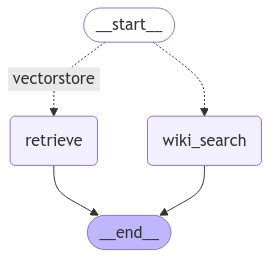

In [17]:
from IPython.display import Image, display



try:

    display(Image(app.get_graph().draw_mermaid_png()))

except Exception:

    # This requires some extra dependencies and is optional

    pass

In [18]:


from pprint import pprint



# Run

inputs = {

    "question": "What is AI agent?"

}

for output in app.stream(inputs):

    for key, value in output.items():

        # Node

        pprint(f"Node '{key}':")

        # Optional: print full state at each node

        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)

    pprint("\n---\n")



# Final generation

pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview In a LLM-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components:')


In [19]:
from pprint import pprint



# Run

inputs = {

    "question": "Avengers"

}

for output in app.stream(inputs):

    for key, value in output.items():

        # Node

        pprint(f"Node '{key}':")

        # Optional: print full state at each node

        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)

    pprint("\n---\n")



# Final generation

pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
[Document(id='7e9885f4096c4f3d9df2e9de0e5aab35', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}, page_content='Self-reflection is a vital aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It plays a crucial role in real-